In [1]:
import os
import csv
import struct
import chardet
import numpy as np
import collections
import pandas as pd
from typing import *
from time import time
import seaborn as sns
from sklearn.svm import SVC
from skimage.feature import hog
from numpy import random as rnd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
import matplotlib.font_manager as fm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [11]:
!ls

Logistic Regression.ipynb NHIS_OPEN_GJ_2018_100.csv SVM.ipynb
NHIS_OPEN_GJ_2017_100.csv README.md


# Data Reading

In [2]:
class ReadData():
    def __init__(self, year=2017, required_info_index=None, special_features=None):
        self.year = year
        self.infos = []
        self.data = []
        self.labels = []
        self.no_data = []
        self.data_infos = []
        self.required_info_index = required_info_index
#         self.required_info_index = [2, 3, 5, 6, 7, 12, 13, 15, 16, 17, 18, 
#                                19, 20, 21, 22, 23, 24, 25, 26]
        self.no_data_count = collections.defaultdict(int)
        
    def read(self, DATASIZE=None, FBS_PIVOT=120, calculate_BMI=True):
        year = self.year
        print(f'Reading year {self.year}')
        if not DATASIZE:
            DATASIZE = float('inf')
        if year == 2017:
            FILENAME = 'NHIS_OPEN_GJ_2017_100.csv'
        elif year == 2018:
            FILENAME = 'NHIS_OPEN_GJ_2018_100.csv'
        else:
            raise Exception('year should be 2017 or 2018. default=2017')
            
        
        with open(FILENAME, 'rb') as f:
            ENCODING = chardet.detect(f.readline())['encoding']
            
        f = open(FILENAME, 'r', encoding=ENCODING)
        rdr = csv.reader(f)
        
        required_info_index = self.required_info_index

        for n, col in enumerate(rdr):
            required_data = [info for index, info in enumerate(col) if index in required_info_index]
            if n == 0:
                self.infos.append(col)
                self.infos = self.infos[0]
                self.data_infos.append(required_data)
                self.data_infos = self.data_infos[0]
                FBS_INDEX = self.infos.index('식전혈당(공복혈당)')
                
                if calculate_BMI:
                    if '신장(5Cm단위)' not in self.data_infos or '체중(5Kg단위)' not in self.data_infos:
                        calculate_BMI = False
                    else:
                        HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index('신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
                        if WEIGHT_INDEX < HEIGHT_INDEX:
                            raise Exception('selected_features에서 신장을 체중보다 먼저 오도록 설정해주세요.')
                        self.data_infos.append('BMI')
            else:
                FBS = col[FBS_INDEX]
                if '' in required_data or FBS == '':
#                     print(required_data)
                    l = [self.data_infos[i] for i, d in enumerate(required_data) if d == '']
                    for s in l: self.no_data_count[s] += 1
                    self.no_data.append(n)
                else:
                    if calculate_BMI:
                        height, weight = int(required_data.pop(HEIGHT_INDEX)), int(required_data.pop(WEIGHT_INDEX-1))
                        BMI = round(weight / (height * height / 10000), 2)
                        required_data.append(BMI)
#                     if intensity:
#                         for pivot_i, i in enumerate(special_features_index):
#                             if required_data[i] < special_features_pivot[pivot_i]:
# #                                 required_data[i] 
#                                 pass
#                     arr = [val for val in required_data[:-1]]
                    
                    self.data.append(required_data)
                    self.labels.append(1) if int(FBS) >= FBS_PIVOT else self.labels.append(0)
                    
            if n >= DATASIZE:
                break

        f.close()
        if calculate_BMI:
            self.data_infos.pop(HEIGHT_INDEX)
            self.data_infos.pop(WEIGHT_INDEX-1)
        X = np.array(self.data)
        X = X.astype(np.float64)
        y = np.array(self.labels)
        
        print(f"Reading year {year}'s data done")
        print(f'Size of X = {len(X)}, y = {len(y)}')
        print(f'당뇨병 판별 공복혈당 기준 수치 : {FBS_PIVOT}')
        counts = np.unique(y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'X has {X.shape[1]} features')
        print(f'Size of data with empty value = {len(self.no_data)}')
        print(f'Selected Features : {self.data_infos}\n')
        print(f'Sample Data : {X[0]}')
        return [X, y]

# Input Features

In [3]:
default_features = ['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드',
                    '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)',
                    '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
                    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', 
                    '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',
                    '흡연상태', '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무',
                    '치아마모증유무', '제3대구치(사랑니)이상', '치석', '데이터공개일자']

selected_features = ['트리글리세라이드', 'LDL콜레스테롤', '신장(5Cm단위)', '체중(5Kg단위)']
features_index = []

for feature in selected_features:
    if feature not in default_features:
        raise Exception(f"'{feature}'는 데이터에 없습니다.")
    features_index.append(default_features.index(feature))
features_index.sort()

# Read Data

In [194]:
# obj = ReadData(year=2017 or 2018, required_info_index = features_index)
data2017 = ReadData(year=2017, required_info_index=features_index)
# X, y = obj.read(calculate_BMI = 체중, 키를 BMI지수로 환산, FBS_PIVOT =  당노병 판단 기준 혈당)
X, y = data2017.read(calculate_BMI=True, FBS_PIVOT=120, intensity=False)

Reading year 2017
Reading year 2017's data done
Size of X = 997087, y = 997087
당뇨병 판별 공복혈당 기준 수치 : 120
당뇨병 판별 환자 수 : 101704, 비당뇨병 판별수 : 895383

X has 5 features
Size of data with empty value = 2913
Selected Features : ['식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', 'BMI']

Sample Data : [ 99.   193.    92.   126.    25.95]


In [ ]:
dict(data2017.no_data_count)

In [6]:
# obj = ReadData(year=2017 or 2018, required_info_index = features_index)
data2018 = ReadData(year=2018, required_info_index = features_index)
# X, y = obj.read(calculate_BMI = 체중, 키를 BMI지수로 환산, FBS_PIVOT =  당노병 판단 기준 혈당)
X, y = data2018.read(calculate_BMI=True, FBS_PIVOT=140)
clear_output()
dict(data2018.no_data_count)

{'총콜레스테롤': 667244,
 '트리글리세라이드': 667252,
 'HDL콜레스테롤': 667254,
 'LDL콜레스테롤': 674122,
 '음주여부': 354943,
 '요단백': 10570,
 '수축기혈압': 5730,
 '이완기혈압': 5730,
 '혈색소': 5914,
 '혈청크레아티닌': 5906,
 '(혈청지오티)AST': 5906,
 '(혈청지오티)ALT': 5906,
 '감마지티피': 5909,
 '허리둘레': 414,
 '흡연상태': 234}

# Scaling

In [5]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X[:])
def scale_robust(X_train, X_test):
    robustScaler = RobustScaler()
    robustScaler.fit(X_train[:])
    X_train = robustScaler.transform(X_train[:])
    X_test = robustScaler.transform(X_test[:])
    print(f'Sample Scaled Data : {X_train[0]}')
    return [X_train[:], X_test[:]]

# Split Training, Test Set
(If required)

In [6]:
def split_set(X, y):
    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reset Labels with new FBS Pivot

In [16]:
def reset_fbs(fbs:int, year):
    read_new = ReadData(year=year)
    X, y = read_new.read(FBS_PIVOT=fbs)
    return [X,y]

# Logistic Regression

In [21]:
class DiabetesModelingLR():
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.CROSSVAL=False
        self.SPLIT_DATA = True
        self.RESET_FBS = False
        self.SCALE = True
    def LR(self):
        intensity = True
        X, y = self.X, self.y
        if self.RESET_FBS:
            FBS = 120
            year = 2017
            X, y = reset_fbs(fbs=FBS, year=year)
        if self.SPLIT_DATA:
            X_train, X_test, y_train, y_test = split_set(X, y)
            self.X_train, self.X_test, self.y_train, self.y_test = [
                X_train, X_test, y_train, y_test]
        if X_train.shape[1] != X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            X_train, X_test = scale_robust(X_train, X_test)
            
#         if intensity:
#             for i in range(0, len(X_train)):
#                 for j in range(0, len(X_train[0])):
#                     if X_train[i][j] <= 0:
#                         X_train[i][j] = 0
#             for i in range(0, len(X_test)):
#                 for j in range(0, len(X_test[0])):
#                     if X_test[i][j] <= 0:
#                         X_test[i][j] = 0
                
            
        self.training_size = len(X_train)
        self.testing_size = len(X_test)
        
        self.clf = LogisticRegression(C=1e-2, solver='saga',
                                 penalty='l2')
        if self.CROSSVAL:
            self.clf = LogisticRegressionCV(C=1, cv=5,
                                 penalty='l2', tol=0.1)
        self.clf.fit(X_train, y_train)
        clear_output()
        y_predict = self.clf.predict(X_test)
        
    def show_result(self):
        clf = self.clf
        print('Training size : %d Testing Size : %d' %(self.training_size, self.testing_size))
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

In [263]:
X,y = look.X, look.y

In [264]:
model2017LR = DiabetesModelingLR(X,y)
model2017LR.LR()

In [265]:
model2017LR.show_result()

Training size : 787845 Testing Size : 196962
당뇨병 판별 환자 수 : 99267, 비당뇨병 판별수 : 885540

Accuracy score: 0.2458

              precision    recall  f1-score   support

          건강       0.96      0.17      0.29    177109
          당뇨       0.11      0.95      0.20     19853

    accuracy                           0.25    196962
   macro avg       0.54      0.56      0.24    196962
weighted avg       0.88      0.25      0.28    196962

Confusion Matrix
 [[ 29647 147462]
 [  1086  18767]]


# Data Lookup

In [257]:
#Override
class LookupData(ReadData):
    def __init__(self, required_info_index):
        ReadData.__init__(self)
        self.X = None
        self.y = None
        self.required_info_index = required_info_index
    def read(self, DATASIZE=None, FBS_PIVOT=120, calculate_BMI=True):
        year = self.year
        print(f'Reading year {self.year}')
        if not DATASIZE:
            DATASIZE = float('inf')
        if year == 2017:
            FILENAME = 'NHIS_OPEN_GJ_2017_100.csv'
        elif year == 2018:
            FILENAME = 'NHIS_OPEN_GJ_2018_100.csv'
        else:
            raise Exception('year should be 2017 or 2018. default=2017')
            
        
        with open(FILENAME, 'rb') as f:
            ENCODING = chardet.detect(f.readline())['encoding']
            
        f = open(FILENAME, 'r', encoding=ENCODING)
        rdr = csv.reader(f)
        
        required_info_index = self.required_info_index

        for n, col in enumerate(rdr):
            required_data = [info for index, info in enumerate(col) if index in required_info_index]
            if n == 0:
                self.infos.append(col)
                self.infos = self.infos[0]
                self.data_infos.append(required_data)
                self.data_infos = self.data_infos[0]
                FBS_INDEX = self.infos.index('식전혈당(공복혈당)')
                
                if calculate_BMI:
                    if '신장(5Cm단위)' not in self.data_infos or '체중(5Kg단위)' not in self.data_infos:
                        calculate_BMI = False
                    else:
                        HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index('신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
                        if WEIGHT_INDEX < HEIGHT_INDEX:
                            raise Exception('selected_features에서 신장을 체중보다 먼저 오도록 설정해주세요.')
                        self.data_infos.append('BMI')
            else:
                FBS = col[FBS_INDEX]
                if '' in required_data or FBS == '':
#                     print(required_data)
                    l = [self.data_infos[i] for i, d in enumerate(required_data) if d == '']
                    for s in l: self.no_data_count[s] += 1
                    self.no_data.append(n)
                else:
                    if calculate_BMI:
                        height, weight = int(required_data.pop(HEIGHT_INDEX)), int(required_data.pop(WEIGHT_INDEX-1))
                        BMI = round(weight / (height * height / 10000), 2)
                        required_data.append(BMI)
                        
                    self.data.append(required_data)
                    self.labels.append(1) if int(FBS) >= FBS_PIVOT else self.labels.append(0)
                    
            if n >= DATASIZE:
                break

        f.close()
        if calculate_BMI:
            self.data_infos.pop(HEIGHT_INDEX)
            self.data_infos.pop(WEIGHT_INDEX-1)
        X = np.array(self.data)
        X = X.astype(np.float64)
        y = np.array(self.labels)
        
        print(f"Reading year {year}'s data done")
        print(f'Size of X = {len(X)}, y = {len(y)}')
        print(f'당뇨병 판별 공복혈당 기준 수치 : {FBS_PIVOT}')
        counts = np.unique(y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'X has {X.shape[1]} features')
        print(f'Size of data with empty value = {len(self.no_data)}')
        print(f'Selected Features : {self.data_infos}\n')
        print(f'Sample Data : {X[0]}')
        self.X, self.y = X, y
    
    def filtering(self, filter_features, filter_pivots):
        filter_index = [self.data_infos.index(f) for f in filter_features]
        X_temp = list(self.X[:])
        y_temp = list(self.y[:])
        cor = 0
        for i in range(len(self.X)):
            for j, findex in enumerate(filter_index):
                if self.X[i][findex] >= filter_pivots[j] or self.X[i][findex] <= 30:
                    X_temp.pop(i-cor)
                    y_temp.pop(i-cor)
                    cor += 1
                    
        self.X = np.array(X_temp[:])
        self.y = np.array(y_temp[:])
        
    def lookup(self, lookup_feature:str, pivot:int):
        lookup_index = self.data_infos.index(lookup_feature)
        fbs_index = self.data_infos.index('식전혈당(공복혈당)')
        bmi_index = self.data_infos.index('BMI')
        print('{:>6} {:>16} {:>20} {:>10}'.format('INDEX', lookup_feature, '식전혈당(공복혈당)', 'BMI'))
        for i in range(len(self.X)):
            if y[i] != 1 and self.X[i][lookup_index] > pivot:
                print('{:6} {:>22.0f} {:>28.0f} {:>10}'.format(i, self.X[i][lookup_index], 
                                                               self.X[i][fbs_index], self.X[i][bmi_index]))

In [258]:
selected_features = ['트리글리세라이드', '총콜레스테롤', 'LDL콜레스테롤',
                     '신장(5Cm단위)', '체중(5Kg단위)']
features_index = []

for feature in selected_features:
    if feature not in default_features:
        raise Exception(f"'{feature}'는 데이터에 없습니다.")
    features_index.append(default_features.index(feature))
features_index.sort()
look = LookupData(required_info_index=features_index)
look.read()

Reading year 2017
Reading year 2017's data done
Size of X = 997087, y = 997087
당뇨병 판별 공복혈당 기준 수치 : 120
당뇨병 판별 환자 수 : 101704, 비당뇨병 판별수 : 895383

X has 4 features
Size of data with empty value = 2913
Selected Features : ['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', 'BMI']

Sample Data : [193.    92.   126.    25.95]


In [259]:
filter_features = ['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤']
filter_pivots = [500, 700, 400]
look.filtering(filter_features, filter_pivots)

In [262]:
for i in range(100):
    print(look.X[i], look.y[i])

[193.    92.   126.    25.95] 0
[228.   121.   148.    24.69] 0
[136.   104.    74.    27.55] 0
[201.   106.   104.    26.12] 0
[199.   104.   117.    22.04] 0
[218.  232.   95.   20.2] 0
[196.    75.   115.    24.44] 0
[185.   101.   107.    21.22] 0
[217.   100.   141.    25.95] 0
[195.    83.   118.    24.49] 0
[183.    55.   130.    22.89] 0
[115.   137.    57.    31.22] 1
[183.   214.    89.    24.44] 0
[200.    77.   129.    24.49] 0
[205.   219.   108.    19.53] 0
[113.    35.    62.    22.49] 0
[148.    60.    82.    25.39] 0
[147.    54.    85.    22.49] 0
[180.   169.   103.    29.41] 0
[197.   222.   111.    22.04] 0
[174.   46.   98.   17.3] 0
[207.    57.   134.    21.22] 0
[170.   333.    64.    20.81] 0
[195.   125.   113.    27.55] 0
[156.    55.    86.    21.48] 0
[154.   150.   104.    25.95] 0
[293.   243.   215.    23.78] 0
[231.    63.   152.    21.48] 0
[195.    49.   100.    19.03] 0
[246.   209.   150.    26.16] 0
[191.   231.    94.    24.49] 0
[212.    69.   1

In [246]:
look.lookup(lookup_feature='총콜레스테롤', pivot=500)

 INDEX           총콜레스테롤           식전혈당(공복혈당)        BMI


In [247]:
look.lookup(lookup_feature='트리글리세라이드', pivot=700)

 INDEX         트리글리세라이드           식전혈당(공복혈당)        BMI


In [248]:
look.lookup(lookup_feature='LDL콜레스테롤', pivot=400)

 INDEX         LDL콜레스테롤           식전혈당(공복혈당)        BMI


# Support Vector Machine

In [92]:
class DiabetesModelingSVM():
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.CROSSVAL=False
        self.SPLIT_DATA = True
        self.RESET_FBS = False
    def SVM(self):
        X, y = self.X, self.y
        if self.RESET_FBS:
            FBS = 120
            year = 2017
            X, y = reset_fbs(fbs=FBS, year=year)
        if self.SPLIT_DATA:
            X_train, X_test, y_train, y_test = split_set(X, y)
            self.X_train, self.X_test, self.y_train, self.y_test = [
                X_train, X_test, y_train, y_test]
        if X_train.shape[1] != X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')

        self.training_size = len(X_train)
        self.testing_size = len(X_test)
        self.clf = SVC(random_state=42, decision_function_shape='ovo', kernel='rbf',
                      gamma=0.1, C=0.0001)
#         self.clf = SVC(C=1e-2, multi_class='ovr',
#                                  penalty='l2', solver='liblinear', tol=0.1)
#         if self.CROSSVAL:
#             self.clf = LogisticRegressionCV(C=1, multi_class='ovr', cv=5,
#                                  penalty='l2', solver='saga', tol=0.1)

        self.clf.fit(X_train, y_train)
        clear_output()
        y_predict = self.clf.predict(X_test)
        
    def show_result(self):
        clf = self.clf
        print('Training size : %d Testing Size : %d' %(self.training_size, self.testing_size))
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

## Data Resize Required

In [93]:
model2017SVM = DiabetesModelingSVM(X,y)
model2017SVM.SVM()
# 1h 22m

In [94]:
model2017SVM.show_result()
# 52m

Training size : 797654 Testing Size : 199414
당뇨병 판별 환자 수 : 46063, 비당뇨병 판별수 : 951005

Accuracy score: 0.9537996329244687



c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

          건강       0.95      1.00      0.98    190201
          당뇨       0.00      0.00      0.00      9213

    accuracy                           0.95    199414
   macro avg       0.48      0.50      0.49    199414
weighted avg       0.91      0.95      0.93    199414

Confusion Matrix
 [[190201      0]
 [  9213      0]]


# Grid Search

In [114]:
class GridSearch():
    def __init__(self, grid_parameters, model=LogisticRegression, X=X, y=y):
        self.model = model
        self.grid_parameters = grid_parameters
        self.X = X
        self.y = y
        self.clf = None
        self.best_parameters = None
        self.best_estimator = None
        
    def make_estimator(self, model, X=None, y=None, default_parameters=None,
                       grid_parameters=None, cross_validation:int=5):
        clf = model(**default_parameters)
        estimator = GridSearchCV(clf, grid_parameters, cv=cross_validation, n_jobs=-1)
        estimator.fit(X,y)
        
        return estimator
    
    def grid_search(self):
        X_train, X_test, y_train, y_test = split_set(self.X, self.y)
        self.clf = self.make_estimator(X=X_train, y=y_train, model=self.model,
                                       default_parameters=dict(solver='lbfgs'),
                                       grid_parameters=self.grid_parameters)
        self.best_parameters = clf.best_params_
        self.best_estimator = clf.best_estimator_

        # get best accuracy on training set
        print('Input Grid Parameters')
        print(self.grid_parameters)
        
        print('Accuracy on training set')
        print(round(self.clf.best_score_, 5))

        print('Accuracy on test set')
        print(round(self.best_estimator.score(X_test, y_test), 5))

        print(f'Best Parameters : {self.best_parameters}')

In [115]:
grid_parameters = {
    'C': [1e-1, 1, 1000]
#     'penalty': ['l1', 'l2'],
#     'batch_size':[1, 10, 60, 100, 600]
#     'epochs':[5, 10, 25, 50, 200]
#     'C': [1e-4, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1000], # 1000 means no regularization
#     'solver': ['saga']
}
grid_search_2017_LR = GridSearch(grid_parameters=grid_parameters, model=LogisticRegression)
grid_search_2017_LR.grid_search()

Input Grid Parameters
{'C': [0.1, 1, 1000]}
Accuracy on training set
0.95346
Accuracy on test set
0.9538
Best Parameters : {'C': 0.0001, 'gamma': 0.1}


In [39]:
def scale(train_data, scatter_show_YN=False, kdeplot_show_YN=False):    
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(train_data))
    train_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    %time print(maxAbsScaler.fit(train_data))
    train_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(train_data))
    train_data_standardScaled = pd.DataFrame(standardScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(train_data))
    train_data_robustScaled = pd.DataFrame(robustScaler.transform(train_data), columns=['x1', 'x2'])

    if(kdeplot_show_YN is True):
        kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)    
    
    if(scatter_show_YN is True):
        scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)

In [40]:
def scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    scatter_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'],
                                  title='train_data', size=2, color1='k', color2='c')
    scatter_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'],
                                  title='train_data_minMaxScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'],
                                  title='train_data_maxAbsScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'],
                                  title='train_data_standardScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'],
                                  title='train_data_robustScaled', size=2, color1='g', color2='c')
    
def scatter_sub_draw(sub_ax, x, y, title, size, color1, color2):
    sub_ax.scatter(x, y, s=size, color=color1)
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sub_ax.set_xlabel(x.name)
    sub_ax.set_ylabel(y.name)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color2, linestyle='--', linewidth=0.5)
    sub_ax.axhline(y=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [41]:
def kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    kdeplot_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'], 
                                  title='train_data', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'], 
                                  title='train_data_minMaxScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'], 
                                  title='train_data_maxAbsScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'], 
                                  title='train_data_standardScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'], 
                                  title='train_data_robustScaled', size=1, color1='r', color2='b')
    
def kdeplot_sub_draw(sub_ax, x, y, title, size, color1, color2):
    # sns.kdeplot: Fit and plot a univariate or bivariate kernel density estimate
    import seaborn as sns
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sns.kdeplot(x, ax=sub_ax, shade=True, color=color1)
    sns.kdeplot(y, ax=sub_ax, shade=True, color=color2)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color1, linestyle='--', linewidth=0.5)
    sub_ax.axvline(x=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [44]:
train_data = pd.DataFrame({
    'x1': X[1],
    'x2': X[2]
})

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 1.94 ms, sys: 150 µs, total: 2.09 ms
Wall time: 2.06 ms
MaxAbsScaler(copy=True)
CPU times: user 1.77 ms, sys: 123 µs, total: 1.89 ms
Wall time: 1.96 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 2.01 ms, sys: 366 µs, total: 2.37 ms
Wall time: 2.19 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 2.47 ms, sys: 526 µs, total: 3 ms
Wall time: 2.63 ms


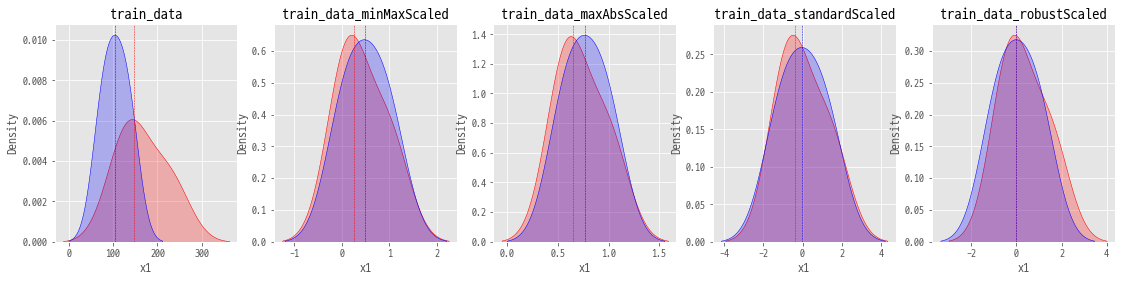

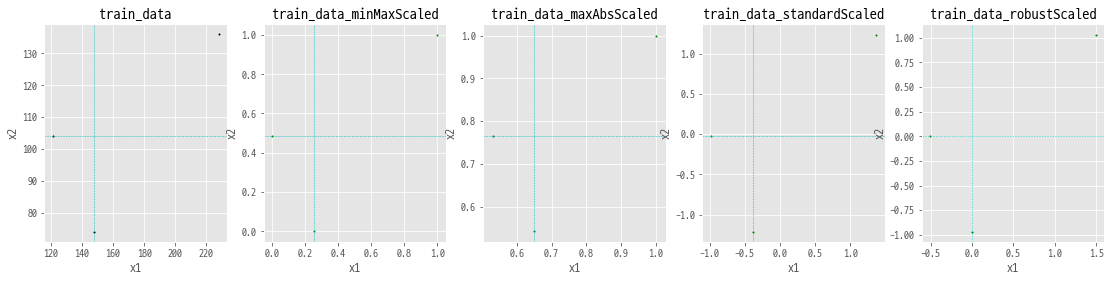

In [45]:
scale(train_data, scatter_show_YN=True, kdeplot_show_YN=True)